In [2]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [5]:

file_paths = ['data1.csv', 'data2.csv', 'data3.csv']


# Initialize empty lists to store data from each dataset
all_X_train, all_y_train = [], []

# Load and process each dataset
for file_path in file_paths:
    # Load the dataset
    try:
        data = pd.read_csv(file_path)
                # Preprocess the text data
        data['text'] = data['text'].str.lower()
        data['text'] = data['text'].replace('[^a-zA-Z0-9\s]', '', regex=True)
        data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', x))

        # Extract text and labels
        X = data['text'].values
        y = data['label'].values

        # Split the dataset into training and testing sets
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

        # Append the training data to the lists
        all_X_train.append(X_train)
        all_y_train.append(y_train)
    except Exception as e:
        print(f"Error loading dataset {file_path}: {e}")



In [6]:
# Check if enough datasets were loaded
if len(all_X_train) >= 3 and len(all_y_train) >= 3:
    # Convert the lists to NumPy arrays or TensorFlow datasets as needed
    X1_train, y1_train = all_X_train[0], all_y_train[0]
    X2_train, y2_train = all_X_train[1], all_y_train[1]
    X3_train, y3_train = all_X_train[2], all_y_train[2]

In [7]:
    # Example: Convert to TensorFlow datasets if needed
    train_dataset1 = tf.data.Dataset.from_tensor_slices((X1_train, y1_train))
    train_dataset2 = tf.data.Dataset.from_tensor_slices((X2_train, y2_train))
    train_dataset3 = tf.data.Dataset.from_tensor_slices((X3_train, y3_train))


#gloabal model


In [8]:

    # Define model parameters
    vocab_size = 10000  # adjust as needed based on your data
    embedding_dim = 50  # adjust as needed based on your data
    max_length = 100  # adjust as needed based on your data

In [9]:

# Define a simple text classification model
def create_text_model():
    model = tf.keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification for depression (0 or 1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Initialize a global text model on the central server
global_text_model = create_text_model()

In [11]:
# Tokenize and pad the text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X1_train_sequences = tokenizer.texts_to_sequences(X1_train)
X1_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X1_train_sequences, maxlen=max_length)

X2_train_sequences = tokenizer.texts_to_sequences(X2_train)
X2_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X2_train_sequences, maxlen=max_length)

X3_train_sequences = tokenizer.texts_to_sequences(X3_train)
X3_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X3_train_sequences, maxlen=max_length)

In [12]:

# Simulate local datasets on three clients
client1_data = (X1_train_padded, y1_train)  # Replace with your actual data
client2_data = (X2_train_padded, y2_train)  # Replace with your actual data
client3_data = (X3_train_padded, y3_train)  # Replace with your actual data



#model training

Training Accuracy - Client 1: 0.8927878141403198
Training Accuracy - Client 2: 0.9445917010307312
Training Accuracy - Client 3: 0.8882534503936768
Training Accuracy - Client 1: 0.9658796787261963
Training Accuracy - Client 2: 0.9731101989746094
Training Accuracy - Client 3: 0.9259639978408813
Training Accuracy - Client 1: 0.9755821228027344
Training Accuracy - Client 2: 0.9798486232757568
Training Accuracy - Client 3: 0.9508511424064636
Training Accuracy - Client 1: 0.9770374894142151
Training Accuracy - Client 2: 0.9862676858901978
Training Accuracy - Client 3: 0.9693043231964111
Training Accuracy - Client 1: 0.9810802340507507
Training Accuracy - Client 2: 0.9895570278167725
Training Accuracy - Client 3: 0.9800276756286621


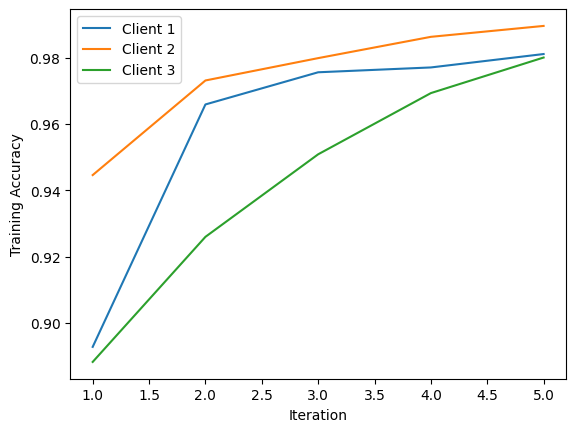

In [13]:
import matplotlib.pyplot as plt

# ...

# Lists to store training accuracies for each client
train_acc1_list, train_acc2_list, train_acc3_list = [], [], []

# Federated Learning Iterations
num_iterations = 5

for iteration in range(num_iterations):
    # Create local text models for each client and set their weights to match the global model
    client1_text_model = create_text_model()
    client1_text_model.set_weights(global_text_model.get_weights())

    client2_text_model = create_text_model()
    client2_text_model.set_weights(global_text_model.get_weights())

    client3_text_model = create_text_model()
    client3_text_model.set_weights(global_text_model.get_weights())

    # Compile local models
    client1_text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    client2_text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    client3_text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the local text models on each client's data
    history1 = client1_text_model.fit(*client1_data, epochs=5, verbose=0)
    history2 = client2_text_model.fit(*client2_data, epochs=5, verbose=0)
    history3 = client3_text_model.fit(*client3_data, epochs=5, verbose=0)

    # Access and print training accuracy from the history object
    train_acc1 = history1.history['accuracy'][-1]
    train_acc2 = history2.history['accuracy'][-1]
    train_acc3 = history3.history['accuracy'][-1]

    # Append training accuracies to the lists
    train_acc1_list.append(train_acc1)
    train_acc2_list.append(train_acc2)
    train_acc3_list.append(train_acc3)

    print(f"Training Accuracy - Client 1: {train_acc1}")
    print(f"Training Accuracy - Client 2: {train_acc2}")
    print(f"Training Accuracy - Client 3: {train_acc3}")

    # Update the global text model using the averaged weights
    averaged_text_weights = [
        (w1 + w2 + w3) / 3 for w1, w2, w3 in zip(
            client1_text_model.get_weights(),
            client2_text_model.get_weights(),
            client3_text_model.get_weights()
        )
    ]
    global_text_model.set_weights(averaged_text_weights)

# Plotting the training accuracy over iterations
plt.plot(range(1, num_iterations + 1), train_acc1_list, label='Client 1')
plt.plot(range(1, num_iterations + 1), train_acc2_list, label='Client 2')
plt.plot(range(1, num_iterations + 1), train_acc3_list, label='Client 3')
plt.xlabel('Iteration')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()


In [16]:
# Save the global model
global_text_model.save('global_text_model.h5')


#testing the global on client dataset

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pandas as pd

# Replace "path_to_your_model.h5" with the actual path to your saved model file
model_path = "global_text_model.h5"

# Load the saved model
loaded_model = load_model(model_path)

# Load your specific dataset
# Replace "path_to_your_dataset.csv" with the actual path to your dataset file
dataset_path = "data1.csv"
df_specific = pd.read_csv(dataset_path)

# Preprocess the text data in the same way as during training
df_specific['text'] = df_specific['text'].str.lower()
df_specific['text'] = df_specific['text'].replace('[^a-zA-Z0-9\s]', '', regex=True)

# Tokenize and pad the input text for predictions
X_specific = df_specific['text'].values
X_specific_sequences = tokenizer.texts_to_sequences(X_specific)
X_specific_padded = pad_sequences(X_specific_sequences, maxlen=100, padding='post', truncating='post')

# Make predictions on the specific dataset
predictions_specific = loaded_model.predict(X_specific_padded)

# Convert the predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
binary_predictions_specific = (predictions_specific > 0.5).astype(int)


# Replace "y_specific" with the actual labels column in your dataset
y_specific = df_specific['label'].values

# Evaluate the model performance on the specific dataset
accuracy_specific = accuracy_score(y_specific, binary_predictions_specific)
conf_matrix_specific = confusion_matrix(y_specific, binary_predictions_specific)
classification_rep_specific = classification_report(y_specific, binary_predictions_specific)

print(f"Specific Dataset Accuracy: {accuracy_specific}")
print("Confusion Matrix:")
print(conf_matrix_specific)
print("Classification Report:")
print(classification_rep_specific)


242/242 [==============================] - 2s 6ms/step
Specific Dataset Accuracy: 0.7490297542043984
Confusion Matrix:
[[3859   41]
 [1899 1931]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      3900
           1       0.98      0.50      0.67      3830

    accuracy                           0.75      7730
   macro avg       0.82      0.75      0.73      7730
weighted avg       0.82      0.75      0.73      7730



# testing on a given string

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Replace "path_to_your_model.h5" with the actual path to your saved model file
model_path = "global_text_model.h5"

# Load the saved model
loaded_model = load_model(model_path)

# Assuming you already have the tokenizer loaded from previous code
# If not, you should load it or re-create it based on your training tokenizer

# Function to test the model on a specific text example
def test_model_on_text(text_example, true_label, tokenizer, max_sequence_length=100):
    # Preprocess the text using regular expressions
    text_example = text_example.lower()
    text_example = re.sub(r'[^a-zA-Z0-9\s]', '', text_example)

    # Tokenize and pad the input text
    text_sequences = tokenizer.texts_to_sequences([text_example])
    text_padded = pad_sequences(text_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    # Make predictions
    prediction = loaded_model.predict(text_padded)

    # Convert the prediction to a binary value (0 or 1) based on a threshold (e.g., 0.5)
    binary_prediction = (prediction > 0.5).astype(int)

    # Calculate accuracy
    accuracy = 1 if binary_prediction == true_label else 0

    return binary_prediction, accuracy

# Test the model on a specific text example with the true label
specific_text_example = "me think think lost matter point never felt want much."
true_label = 0


result, accuracy = test_model_on_text(specific_text_example, true_label, tokenizer)

print(f"Prediction for '{specific_text_example}': {result}")



1/1 [==============================] - 0s 78ms/step
Prediction for 'me think think lost matter point never felt want much.': [[0]]
